<font color='blue'><i>Please upvote if you find notebook useful</i></font><br>

<h2>Key Machine Learning Techniques used in this Notebook</h2>
<ul>
    <li>Creating Dummy features out of categorical features
    <li>Generating aggregated features with groupby
    <li>Replacing categorical features with Ranks
    <li>Dimensionality Reduction on sparse matrix (TruncatedSVD)
    <li>Feature extraction from text features (TfidfVectorizer)
    <li>StratifiedKFold for creating cross validation sets
</ul>
<font color='red'><i>Note: This is not a tutorial to above mentioned techniques. But their implementation on a complex dataset</i></font>


<h2>Problem Statement</h2>

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to <b>predict revenue per customer.</b> 

<br><br>
Submissions are scored on the <b>root mean squared error</b>. RMSE or RMSD is defined as:

![RSME or RSMD](https://wikimedia.org/api/rest_v1/media/math/render/svg/eeb88fa0f90448e9d1a67cd7a70164f674aeb300)

<br><br>
 Final submission deadline: <b>November 15, 2018</b>
<h2>GStore EDA</h2>
<ol>
    <li>Data Preparation
        <ul>
            <li>Moved Json Feature extraction to another [notebook ](https://www.kaggle.com/rahullalu/gstore-datapreparation)
            <li>Will be reading files generated by above notebook
        </ul>
  <li>Further Data Preparation
          <ul>
           <li>Converting a set of categorical features to dummy features. Where categories are less than 10
           <li>Replacing categorical features with categories greater than 10 with ranked values calculated on Revenue per Transaction
              <li>Factorize <b>tsadclick_gclId</b> and <b>geoNetwork_networkDomain</b>
          </ul>
      <li>Exploratory Analysis <font color="red">(work in progress)</font>
<ul>
    <li>Number of transactions generating revenue
    <li><b>Revenue mean</b> and <b>Transactions with revenue count</b> by browser
    <li><b>Revenue mean</b> and <b>transactions with revenue count</b> by operating system
    <li><b>Revenue, Transactions with Reveune</b> and <b>Total Transactions</b> by date    
<li>Maximum Mean Revenue is for country <b>Anguilla</b> and Count of Transactions with Revenue is just one
 <li>Maximum Count of Transactions with Revenue for country <b>United States</b> and Mean Revenue is 3982082.36
 <li>This gives opportunity for discarding observations which can cause baised model,e.g. observations covering country <b>Anguilla</b>
  <li>Maximum Mean Revenue is for city <b>Fort Collins</b> and Count of Transactions with Revenue is 7
 <li>Maximum Count of Transactions with Revenue for city <b>Mountain View</b> and Mean Revenue is 3084426.18
 <li>For number of cities high Revenue is generated by very few transactions.
 <li>Many cities have zero revenue although there are number of non zero transactions. There requires a bit for further analysis.
 </ul>
    <li>Developing baseline model
        <ul>
            <li>Grouped data by <b>fullVisitorId</b> and applied aggregates
            <li>Converting <b>totals_transactionRevenue</b> to natual log
             <li>Creating a dummy traget category feature giving revenue or no revenue. This feature will be used for StratifiedKfold  
            <li>Developing LGBMRegressor model
            <li>Basic idea is to achieve best score by data preparation using  single model 
        </ul>
     <li>While preparing submission we have to keep few points in mind
<ul>
<li>Number of observations in test set 804684
<li>Number of entries in submission file 617242
<li>Read train and test file with following data type setup <i><b>dtype={'fullVisitorId':str,'date':str,'sessionId':str,'visitId':str,'visitStartTime':str}</b></i>
<li>Therefore after predicting group predicted values on <i>fullVisitorId</i>, and 
<li>Then creating a join with submission dataframe to get final submission file
<li>I was missing this trick in first go and LB score was 2.005 :). Now it is 1.4431
<li>By further data preparation score improved from 1.4431 to 1.4389
<li>Grouped data by <b>fullVisitorId</b> and applied aggregates score improved from 1.4389 to 1.4281 
<li>Score further improved from 1.4281 to 1.470 by converting feature <b>geoNetwork_networkDomain</b> into text and using TfidfVectorizer for text feature extraction
<li>Score is improved from 1.4270 to 1.4260 by dropping observation for country <b>Anguilla</b>. This improvement is direct outcome of EDA
    
</ul>

</ol>


In [1]:
#IMPORTING REQUIRED LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import gc
gc.enable()


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



In [6]:
#DATASET VIEW
path1="../input/"
data_files=list(os.listdir(path1))
df_files=pd.DataFrame(data_files,columns=['File_Name'])
df_files['Size_in_MB']=df_files.File_Name.apply(lambda x:round(os.stat(path1+x).st_size/(1024*1024),2))
df_files

,File_Name,Size_in_MB
0,test.csv,1284.45
1,train.csv,1433.78
2,prepared_train,232.53
3,prepared_test,187.74
4,sample_submission.csv,14.06
5,train.csv.zip,57.55
6,test.csv.zip,53.28
7,sample_submission.csv.zip,5.22


In [8]:
#DATASET VIEW
path1="../input/ga-customer-revenue-prediction/"
path2='../input/gstore-prepared-dataset/'
data_files=['../input/prepared_train',
            '../input/prepared_test']
df_files=pd.DataFrame(data_files,columns=['File_Name'])
df_files['Size_in_MB']=df_files.File_Name.apply(lambda x:round(os.stat(x).st_size/(1024*1024),2))
df_files

,File_Name,Size_in_MB
0,../input/prepared_train,232.53
1,../input/prepared_test,187.74


In [9]:
#All functions

#FUNCTION FOR PROVIDING FEATURE SUMMARY
def feature_summary(df_fa):
    print('DataFrame shape')
    print('rows:',df_fa.shape[0])
    print('cols:',df_fa.shape[1])
    col_list=['Null','Unique_Count','Data_type','Max/Min','Mean','Std','Skewness','Sample_values']
    df=pd.DataFrame(index=df_fa.columns,columns=col_list)
    df['Null']=list([len(df_fa[col][df_fa[col].isnull()]) for i,col in enumerate(df_fa.columns)])
    #df['%_Null']=list([len(df_fa[col][df_fa[col].isnull()])/df_fa.shape[0]*100 for i,col in enumerate(df_fa.columns)])
    df['Unique_Count']=list([len(df_fa[col].unique()) for i,col in enumerate(df_fa.columns)])
    df['Data_type']=list([df_fa[col].dtype for i,col in enumerate(df_fa.columns)])
    for i,col in enumerate(df_fa.columns):
        if 'float' in str(df_fa[col].dtype) or 'int' in str(df_fa[col].dtype):
            df.at[col,'Max/Min']=str(round(df_fa[col].max(),2))+'/'+str(round(df_fa[col].min(),2))
            df.at[col,'Mean']=df_fa[col].mean()
            df.at[col,'Std']=df_fa[col].std()
            df.at[col,'Skewness']=df_fa[col].skew()
        df.at[col,'Sample_values']=list(df_fa[col].unique())
           
    return(df.fillna('-'))

#FUNCTION FOR READING DICTIONARY ITEMS AND HANDLING KEYERROR
def get_val(x,col):
    try:
        y=x[col]
    except:
        y=np.nan
    return(y)

#FUNCTION FOR CALCULATING RSME
def rsme(y,pred):
    return(mean_squared_error(y,pred)**0.5)

In [10]:
%%time
#READING TRAINING AND TEST DATASET
print('reading train dataset...')
df_train=pd.read_csv(data_files[0],dtype={'fullVisitorId':str})
print('reading test dataset...')
df_test=pd.read_csv(data_files[1],dtype={'fullVisitorId':str})
print('data reading complete')

reading train dataset...
reading test dataset...
data reading complete
CPU times: user 8.35 s, sys: 675 ms, total: 9.03 s
Wall time: 8.64 s


In [11]:
#CHECKING TOP FIVE TRAIN OBSERVATIONS OR ROWS
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_deviceCategory,device_operatingSystem,device_isMobile,...,totals_bounces,totals_pageviews,totals_hits,totals_newVisits,totals_transactionRevenue,tsadclick_isVideoAd,tsadclick_page,tsadclick_gclId,tsadclick_slot,tsadclick_adNetworkType
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,desktop,Windows,False,...,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,desktop,Macintosh,False,...,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,desktop,Windows,False,...,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,desktop,Linux,False,...,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,mobile,Android,True,...,1.0,1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [12]:
#FEATURE SUMMARY FOR TRAIN DATASET
feature_summary(df_train)

DataFrame shape
rows: 903653
cols: 35


,Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
channelGrouping,0,8,object,-,-,-,-,"[Organic Search, Referral, Paid Search, Affili..."
date,0,366,int64,20170801/20160801,2.01659e+07,4697.7,-0.0666772,"[20160902, 20170126, 20170623, 20170312, 20170..."
fullVisitorId,0,714167,object,-,-,-,-,"[1131660440785968503, 377306020877927890, 3895..."
sessionId,0,902755,object,-,-,-,-,"[1131660440785968503_1472830385, 3773060208779..."
visitId,0,886303,int64,1501657193/1470034812,1.48501e+09,9.02212e+06,0.194051,"[1472830385, 1472880147, 1472865386, 147288121..."
visitNumber,0,384,int64,395/1,2.2649,9.28373,19.9981,"[1, 2, 3, 5, 11, 4, 57, 6, 56, 7, 20, 8, 15, 9..."
visitStartTime,0,887159,int64,1501657193/1470034812,1.48501e+09,9.02212e+06,0.194052,"[1472830385, 1472880147, 1472865386, 147288121..."
device_deviceCategory,0,3,object,-,-,-,-,"[desktop, mobile, tablet]"
device_operatingSystem,4695,20,object,-,-,-,-,"[Windows, Macintosh, Linux, Android, iOS, Chro..."
device_isMobile,0,2,bool,-,-,-,-,"[False, True]"


In [14]:
#CHECKING TOP 5 TEST OBSERVATIONS OR ROWS
df_test.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_deviceCategory,device_operatingSystem,device_isMobile,...,totals_bounces,totals_pageviews,totals_hits,totals_newVisits,totals_transactionRevenue,tsadclick_isVideoAd,tsadclick_page,tsadclick_gclId,tsadclick_slot,tsadclick_adNetworkType
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,desktop,Macintosh,False,...,NaN,4.0,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,desktop,Windows,False,...,NaN,5.0,5.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,desktop,Macintosh,False,...,NaN,7.0,7.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,mobile,iOS,True,...,NaN,4.0,8.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,desktop,Macintosh,False,...,NaN,4.0,9.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [15]:
#FEATURE SUMMARY FOR TEST DATASET
feature_summary(df_test)

DataFrame shape
rows: 804684
cols: 35


,Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
channelGrouping,0,8,object,-,-,-,-,"[Organic Search, Paid Search, Display, Direct,..."
date,0,272,int64,20180430/20170802,2.0175e+07,4573.1,0.296963,"[20171016, 20171130, 20180415, 20171110, 20171..."
fullVisitorId,0,617242,object,-,-,-,-,"[6167871330617112363, 0643697640977915618, 605..."
sessionId,0,803863,object,-,-,-,-,"[6167871330617112363_1508151024, 0643697640977..."
visitId,0,779504,int64,1525157818/1501656404,1.51334e+09,6.676e+06,0.0375182,"[1508151024, 1508175522, 1508143220, 150819353..."
visitNumber,0,446,int64,457/1,2.41409,9.43174,22.1655,"[2, 1, 6, 4, 22, 3, 17, 18, 5, 10, 14, 8, 102,..."
visitStartTime,0,780264,int64,1525157818/1501657203,1.51334e+09,6.676e+06,0.0375182,"[1508151024, 1508175522, 1508143220, 150819353..."
device_deviceCategory,0,3,object,-,-,-,-,"[desktop, mobile, tablet]"
device_operatingSystem,7120,22,object,-,-,-,-,"[Macintosh, Windows, iOS, Linux, Android, Chro..."
device_isMobile,0,2,bool,-,-,-,-,"[False, True]"


In [16]:
#CREATING COPY OF TRAIN DATA SET
train_cpy=df_train.copy()

In [17]:
#ADDING ANOTHER FEATURE revenue_status TO INDICATE PRESENCE/ABSENCE OF REVENUE FOR EACH OBSERVATION
df_train['revenue_status']=df_train.totals_transactionRevenue.apply(lambda x: 0 if x==0 else 1)

<h2>Analyzing Each Feature one by one</h2>
Will try to understand following points
<ul>
<li>Number of transactions generating revenue
<li>'Revenue mean' and 'Transactions with revenue count' by browser
<li>'Revenue mean' and 'Transactions with revenue count' by operating system
<li>Revenue, Transactions with Reveune and Total Transactions by date
 <li>Maximum Mean Revenue is for country <b>Anguilla</b> and Count of Transactions with Revenue is just one
 <li>Maximum Count of Transactions with Revenue for country <b>United States</b> and Mean Revenue is 3982082.36
 <li>This gives opportunity for discarding observations which can cause baised model,e.g. observations covering country <b>Anguilla</b>
  <li>Maximum Mean Revenue is for city <b>Fort Collins</b> and Count of Transactions with Revenue is 7
 <li>Maximum Count of Transactions with Revenue for city <b>Mountain View</b> and Mean Revenue is 3084426.18
 <li>For number of cities high Revenue is generated by very few transactions.
 <li>Many cities have zero revenue although there are number of non zero transactions. There requires a bit for further analysis.
</ul>
<font color='red'>work in progress...</font>

<h2>Understanding Number Of Transations Generating Revenue</h2>
<ul>
 <li>Only 1.27% Transactions generate revenue
</ul>

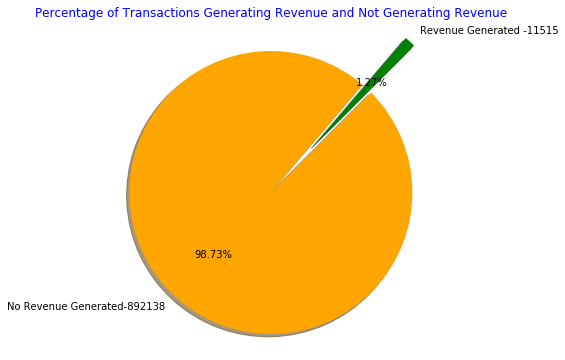

In [18]:
#UNDERSTANDING NUMBER OF TRANSACTIONS GENERATING REVENUE
pie_labels=['Revenue Generated -'+str(df_train['revenue_status'][df_train.revenue_status==1].count()),'No Revenue Generated-'+
            str(df_train['revenue_status'][df_train.revenue_status==0].count())]
pie_share=[df_train['revenue_status'][df_train.revenue_status==1].count()/df_train['revenue_status'].count(),
           df_train['revenue_status'][df_train.revenue_status==0].count()/df_train['revenue_status'].count()]
figureObject, axesObject = plt.subplots(figsize=(6,6))
pie_colors=('green','orange')
pie_explode=(.30,.15)
axesObject.pie(pie_share,labels=pie_labels,explode=pie_explode,autopct='%.2f%%',colors=pie_colors,startangle=45,shadow=True)
axesObject.axis('equal')
plt.title('Percentage of Transactions Generating Revenue and Not Generating Revenue',color='blue',fontsize=12)
plt.show()

<h2>Understanding Number Of Transations Generating Revenue by Browser</h2>
<ul>
 <li>There are total 128 unique values for browser
 <li>But revenue is generated using only 9 browsers
 <li>Maximum mean revenue is generated using firefox
 <li>Maximum transactions with revenue are done using chrome
 <li>This shows few browsers are more important for predicting revenue.
</ul>

,device_browser,totals_transactionRevenue_mean,revenue_status_count
15,Firefox,2409461.27,37069
10,Chrome,2229505.52,620364
14,Edge,635273.89,10205
19,Internet Explorer,426092.90,19375
39,Safari,287511.21,182245
2,Amazon Silk,53458.11,561
35,Opera,38162.33,5643
40,Safari (in-app),22448.18,6850
5,Android Webview,14602.67,7865


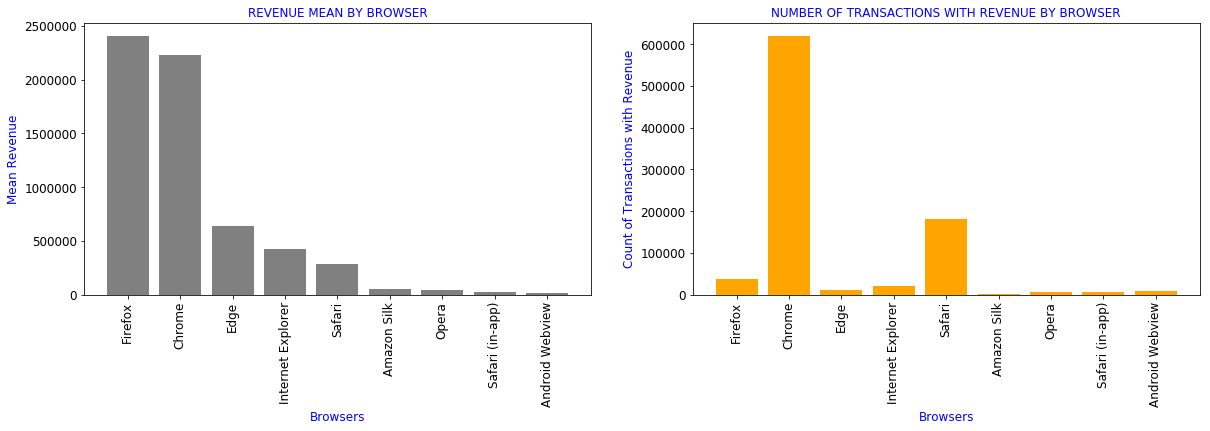

In [19]:
#REVENUE GENERATED BY BROWSERS
df_browser=df_train[['device_browser','totals_transactionRevenue','revenue_status']].groupby(df_train.device_browser).aggregate({'totals_transactionRevenue':['mean'],
                                                                                                              'revenue_status':['count']}).reset_index()
df_browser.columns=['device_browser','totals_transactionRevenue_mean','revenue_status_count']
df=df_browser.sort_values(by='totals_transactionRevenue_mean',ascending=False)[df_browser.totals_transactionRevenue_mean>0]
formatter = {'totals_transactionRevenue_mean':'{:4.2f}'}
display(df.style.format(formatter))

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY BROWSER',color='b',fontsize=12)
plt.xlabel('Browsers',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df)),df.device_browser,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY BROWSER',color='b',fontsize=12)
plt.xlabel('Browsers',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.revenue_status_count,color='orange')
plt.xticks(range(len(df)),df.device_browser,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<h2>Understanding Number Of Transations Generating Revenue by Operating System</h2>
<ul>
 <li>There are total 24 unique values for operating systems
 <li>But revenue is generated using only 7 operating systems
 <li>Maximum mean revenue is generated using chrome os
 <li>Maximum transactions with revenue are done using windows
 <li>This shows few operating systems are more important for predicting revenue.
</ul>

,device_operatingSystem,totals_transactionRevenue_mean,revenue_status_count
2,Chrome OS,6984005.39,26337
6,Macintosh,3372381.41,253938
5,Linux,1253365.30,35034
15,Windows,1134945.73,350072
0,Android,293330.32,123892
18,iOS,205887.71,107665
16,Windows Phone,21710.53,1216


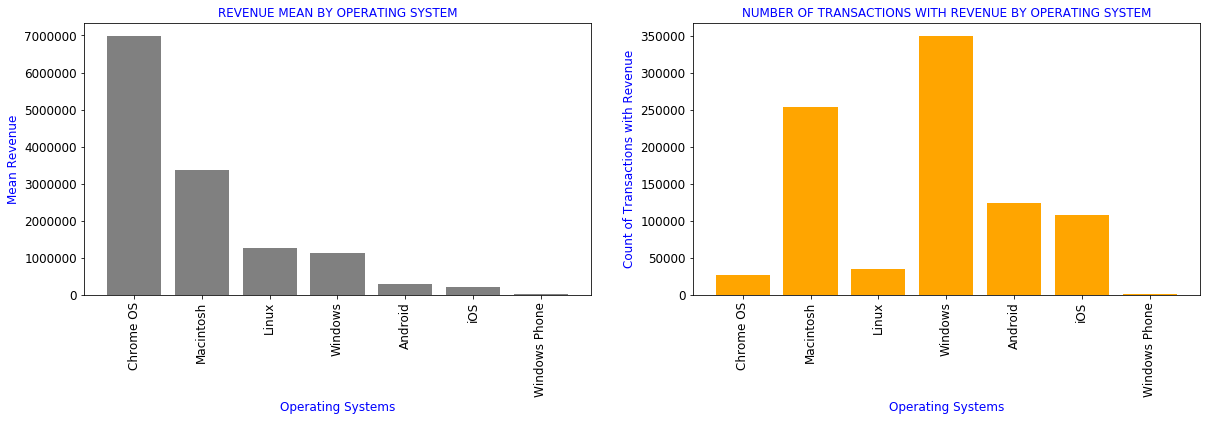

In [20]:
#REVENUE GENERATED BY OPERATING SYSTEM
df_OS=df_train[['device_operatingSystem','totals_transactionRevenue','revenue_status']].groupby(df_train.device_operatingSystem).aggregate({'totals_transactionRevenue':['mean'],
                                                                                                              'revenue_status':['count']}).reset_index()
df_OS.columns=['device_operatingSystem','totals_transactionRevenue_mean','revenue_status_count']
df=df_OS.sort_values(by='totals_transactionRevenue_mean',ascending=False)[df_OS.totals_transactionRevenue_mean>0]
display(df.style.format(formatter))

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY OPERATING SYSTEM',color='b',fontsize=12)
plt.xlabel('Operating Systems',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df)),df.device_operatingSystem,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY OPERATING SYSTEM',color='b',fontsize=12)
plt.xlabel('Operating Systems',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.revenue_status_count,color='orange')
plt.yticks(fontsize=12)
plt.xticks(range(len(df)),df.device_operatingSystem,rotation=90,fontsize=12)
plt.show()

<h2>Understanding Revenue, Transactions with Revenue and Total Transactions by Date</h2>
<ul>
 <li>Revenue mean by date 0.4208 (scaling 1e10) and Revenue by date max value  2.7181 (scaling 1e10)
 <li>Transactions with Revenue by date mean 31.4617 and Transactions with Revenue by date max value 87
 <li>Total Transactions by date mean 2489 and Total Transactions by date max value 4807  
</ul>

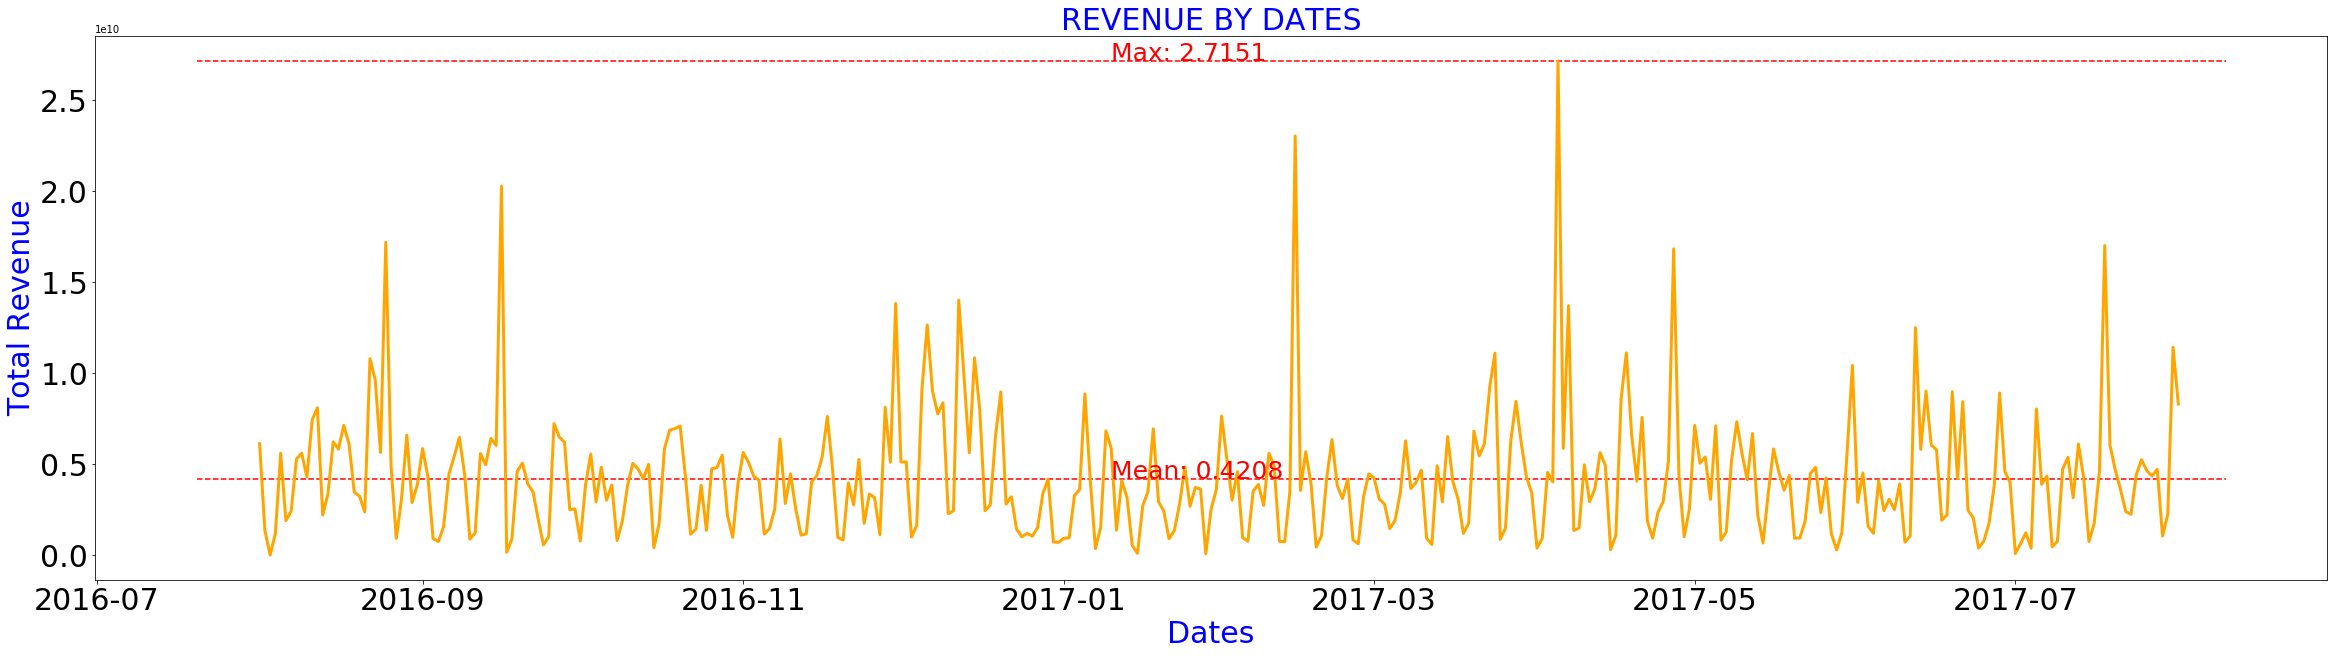

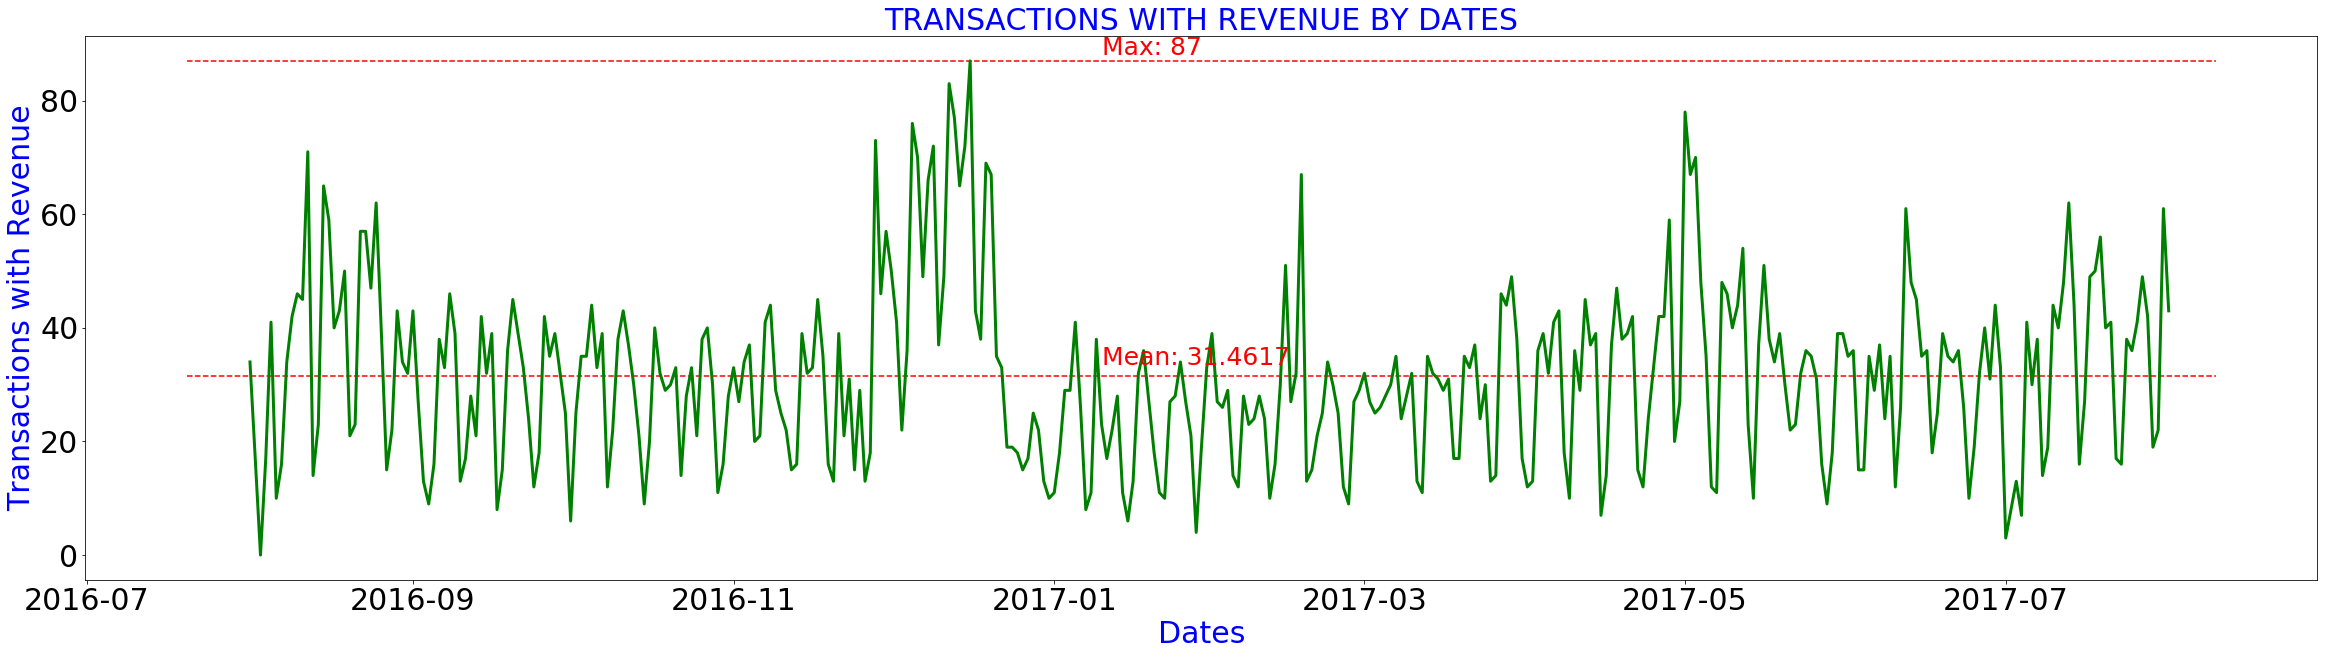

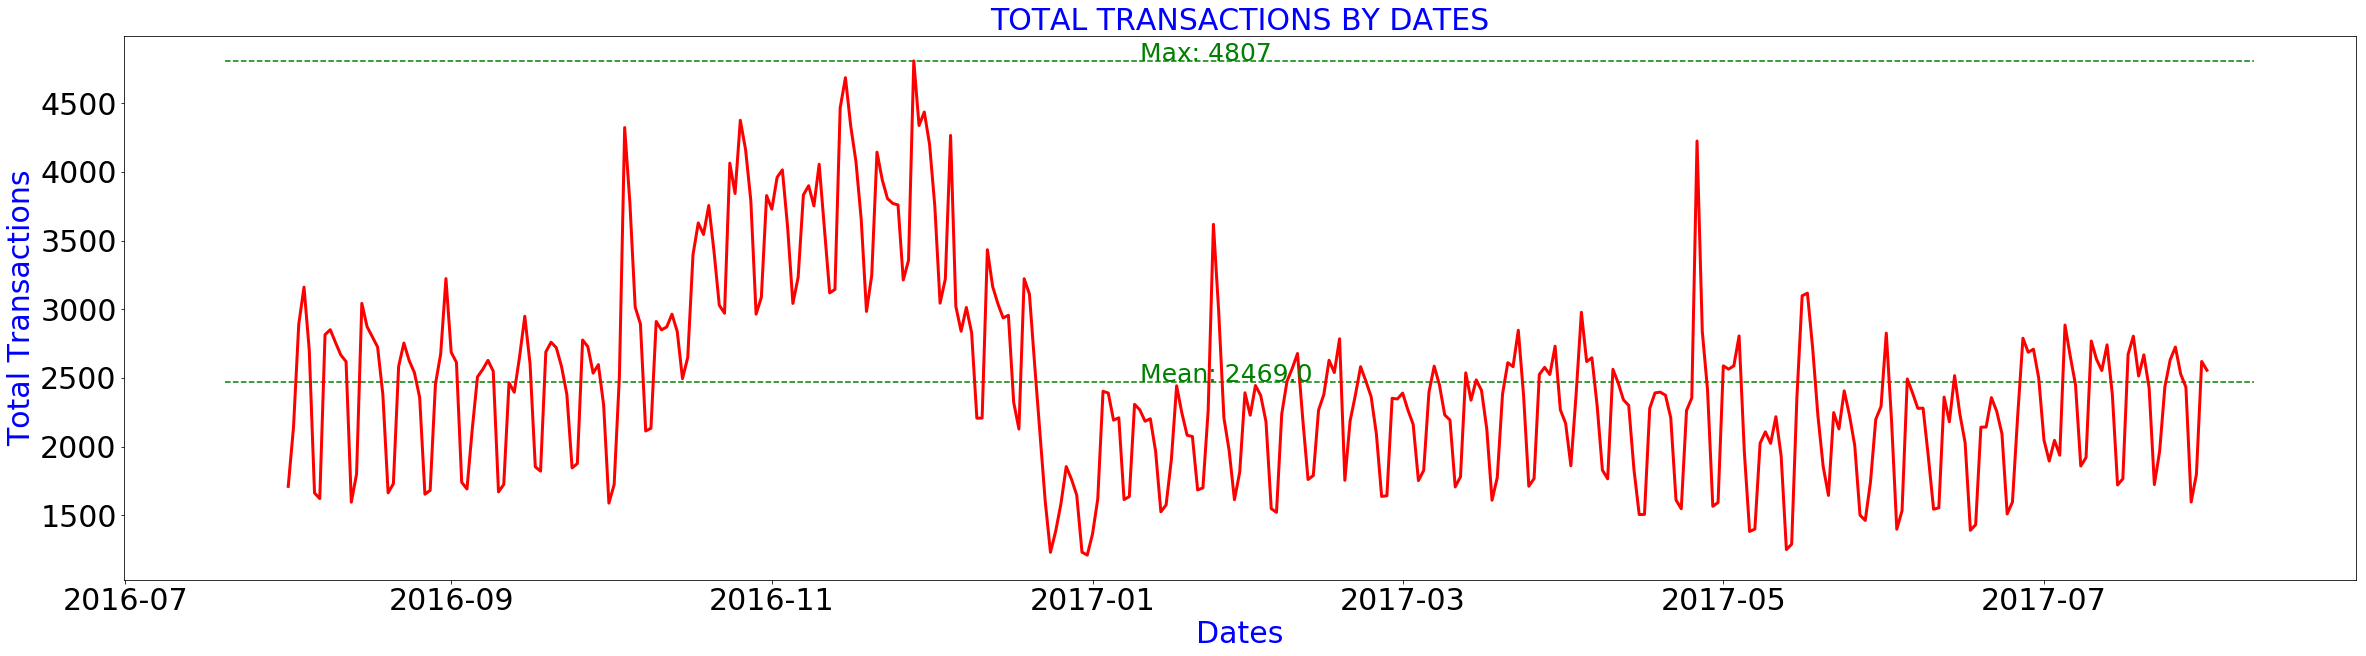

In [21]:
#UNDERSTANDING REVENUE, TRANSACTIONS WITH REVENUE AND TOTAL TRANSACTIONS BY DATE
df=df_train[['date','revenue_status','totals_transactionRevenue']]
df['date']=pd.to_datetime(df['date'],format="%Y%m%d")
df=df.groupby('date').aggregate({'revenue_status':['sum','count'],'totals_transactionRevenue':['sum']}).reset_index()
df.columns=['date','transactions_withRevenue','total_transactions','total_revenue']


#PLOT FOR REVENUE BY DATES
plt.figure(figsize=(40,10))
plt.title("REVENUE BY DATES",fontsize=30,color='b')
plt.xlabel("Dates",fontsize=30,color='b')
plt.ylabel("Total Revenue",fontsize=30,color='b')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(df['date'],df['total_revenue'],color='orange',linewidth=3)
plt.hlines(xmin='2016-07-20',xmax='2017-08-10',y=np.mean(df['total_revenue']),color='r',linestyle='dashed')
plt.text('2017-01-10',np.mean(df['total_revenue'])+2,str('Mean: '+str(round(np.mean(df['total_revenue'])/(10**10),4))),
         color='r',fontsize=25)
plt.hlines(xmin='2016-07-20',xmax='2017-08-10',y=np.max(df['total_revenue']),color='r',linestyle='dashed')
plt.text('2017-01-10',np.max(df['total_revenue'])+2,str('Max: '+str(round(np.max(df['total_revenue'])/(10**10),4))),
         color='r',fontsize=25)
plt.show()

#PLOT FOR TRANSACTIONS WITH REVENUE BY DATES
plt.figure(figsize=(40,10))
plt.title("TRANSACTIONS WITH REVENUE BY DATES",fontsize=30,color='b')
plt.xlabel("Dates",fontsize=30,color='b')
plt.ylabel("Transactions with Revenue",fontsize=30,color='b')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(df['date'],df['transactions_withRevenue'],color='g',linewidth=3)
plt.hlines(xmin='2016-07-20',xmax='2017-08-10',y=np.mean(df['transactions_withRevenue']),color='r',linestyle='dashed')
plt.text('2017-01-10',np.mean(df['transactions_withRevenue'])+2,str('Mean: '+str(round(np.mean(df['transactions_withRevenue']),4))),
         color='r',fontsize=25)
plt.hlines(xmin='2016-07-20',xmax='2017-08-10',y=np.max(df['transactions_withRevenue']),color='r',linestyle='dashed')
plt.text('2017-01-10',np.max(df['transactions_withRevenue'])+1,str('Max: '+str(round(np.max(df['transactions_withRevenue']),4))),
         color='r',fontsize=25)
plt.show()


#PLOT FOR TOTAL TRANSACTIONS BY DATES
plt.figure(figsize=(40,10))
plt.title("TOTAL TRANSACTIONS BY DATES",fontsize=30,color='b')
plt.xlabel("Dates",fontsize=30,color='b')
plt.ylabel("Total Transactions",fontsize=30,color='b')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(df['date'],df['total_transactions'],color='r',linewidth=3)
plt.hlines(xmin='2016-07-20',xmax='2017-08-10',y=np.mean(df['total_transactions']),color='g',linestyle='dashed')
plt.text('2017-01-10',np.mean(df['total_transactions'])+2,str('Mean: '+str(round(np.mean(df['total_transactions']),0))),
         color='g',fontsize=25)
plt.hlines(xmin='2016-07-20',xmax='2017-08-10',y=np.max(df['total_transactions']),color='g',linestyle='dashed')
plt.text('2017-01-10',np.max(df['total_transactions'])+2,str('Max: '+str(round(np.max(df['total_transactions']),0))),
         color='g',fontsize=25)
plt.show()





<h2>Understanding Revenue generated by Device (mobile/non mobile)</h2>
<ul>
 <li>More revenue is generated by non mobile devices
 <li>More transactions with revenue are done from non mobile devices
 
</ul>

,device_isMobile,totals_transactionRevenue_mean,revenue_status_count
0,False,2228389.43,664530
1,True,247736.98,239123


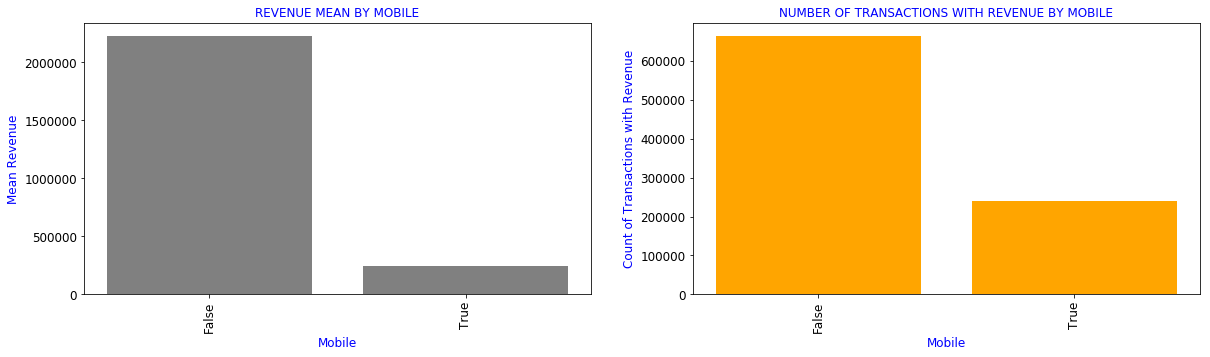

In [22]:
#REVENUE GENERATED BY OPERATING SYSTEM
df_isM=df_train[['device_isMobile','totals_transactionRevenue','revenue_status']].groupby(df_train.device_isMobile).aggregate({'totals_transactionRevenue':['mean'],
                                                                                                              'revenue_status':['count']}).reset_index()
df_isM.columns=['device_isMobile','totals_transactionRevenue_mean','revenue_status_count']
df=df_isM.sort_values(by='totals_transactionRevenue_mean',ascending=False)[df_isM.totals_transactionRevenue_mean>0]
display(df.style.format(formatter))

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY MOBILE',color='b',fontsize=12)
plt.xlabel('Mobile',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df)),df.device_isMobile,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY MOBILE',color='b',fontsize=12)
plt.xlabel('Mobile',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.revenue_status_count,color='orange')
plt.yticks(fontsize=12)
plt.xticks(range(len(df)),df.device_isMobile,rotation=90,fontsize=12)
plt.show()

<h2>Understanding Revenue generated by Country</h2>
<ul>
 <li>Maximum Mean Revenue is for <b>Anguilla</b> and Count of Transactions with Revenue is just one
 <li>Maximum Count of Transactions with Revenue for <b>United States</b> and Mean Revenue is 3982082.36
 <li>This gives opportunity for discarding observations which can cause baised model 
</ul>

'SORTED BY Mean Revenue'

,geoNetwork_country,totals_transactionRevenue_mean,revenue_status_count
6,Anguilla,10990000.00,1
50,Curaçao,6877666.67,30
105,Kenya,6833592.74,771
215,Venezuela,6273405.25,2132
184,St. Lucia,4842083.33,24
211,United States,3982082.36,364744
146,Nigeria,2283817.43,1446
160,Puerto Rico,1643224.04,732
35,Canada,1268875.49,25869
80,Guadeloupe,937241.38,29


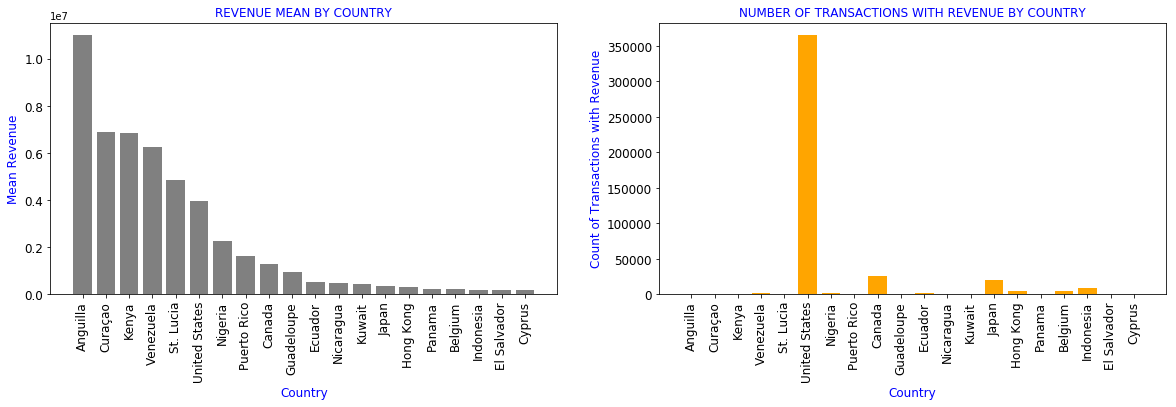

'SORTED BY Count of Transactions with Revenue'

,geoNetwork_country,totals_transactionRevenue_mean,revenue_status_count
211,United States,3982082.36,364744
92,India,13622.60,51140
210,United Kingdom,45180.92,37393
35,Canada,1268875.49,25869
216,Vietnam,0.00,24598
203,Turkey,4990.25,20522
198,Thailand,22994.09,20123
74,Germany,27494.49,19980
27,Brazil,32443.51,19783
101,Japan,341036.44,19731


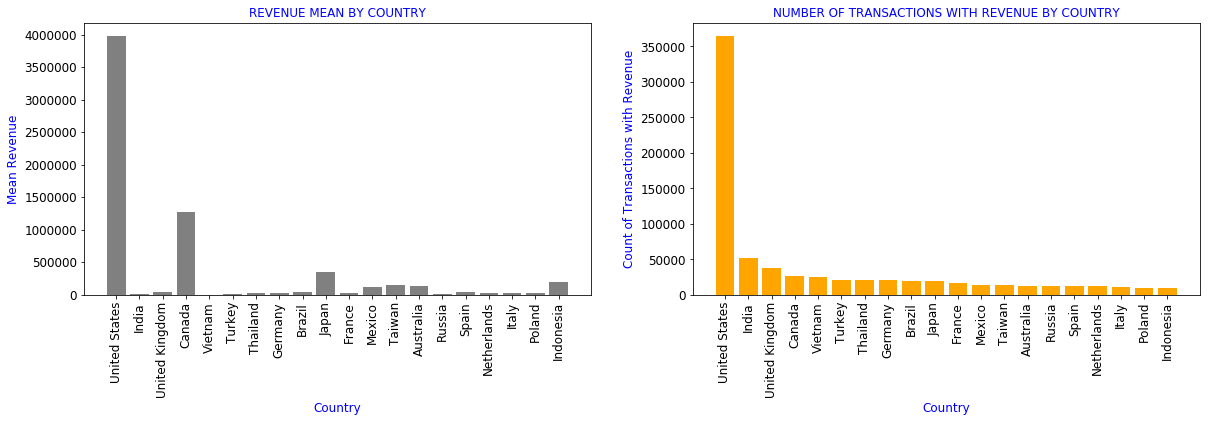

In [23]:
#REVENUE GENERATED BY COUNTRY
df_con=df_train[['geoNetwork_country','totals_transactionRevenue','revenue_status']].groupby(df_train.geoNetwork_country).aggregate({'totals_transactionRevenue':['mean'],
                                                                                                              'revenue_status':['count']}).reset_index()
df_con.columns=['geoNetwork_country','totals_transactionRevenue_mean','revenue_status_count']
df=df_con.sort_values(by='totals_transactionRevenue_mean',ascending=False)[:20]
df1=df_con.sort_values(by='revenue_status_count',ascending=False)[:20]
display('SORTED BY Mean Revenue')
display(df.style.format(formatter))


plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY COUNTRY',color='b',fontsize=12)
plt.xlabel('Country',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df)),df.geoNetwork_country,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY COUNTRY',color='b',fontsize=12)
plt.xlabel('Country',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.revenue_status_count,color='orange')
plt.yticks(fontsize=12)
plt.xticks(range(len(df)),df.geoNetwork_country,rotation=90,fontsize=12)
plt.show()

display('SORTED BY Count of Transactions with Revenue')
display(df1.style.format(formatter))

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY COUNTRY',color='b',fontsize=12)
plt.xlabel('Country',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df1)),df1.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df1)),df1.geoNetwork_country,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY COUNTRY',color='b',fontsize=12)
plt.xlabel('Country',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df1)),df1.revenue_status_count,color='orange')
plt.yticks(fontsize=12)
plt.xticks(range(len(df1)),df1.geoNetwork_country,rotation=90,fontsize=12)
plt.show()

<h2>Understanding Revenue generated by City</h2>
<ul>
 <li>Maximum Mean Revenue is for <b>Fort Collins</b> and Count of Transactions with Revenue is 7
 <li>Maximum Count of Transactions with Revenue for <b>Mountain View</b> and Mean Revenue is 3084426.18
 <li>For number of cities high Revenue is generated by very few transactions.
 <li>Many cities have zero revenue although there are number of non zero transactions. There requires a bit for further analysis.
</ul>

'SORTED BY Mean Revenue'

,geoNetwork_city,totals_transactionRevenue_mean,revenue_status_count
199,Fort Collins,113508571.43,7
351,Milwaukee,56984285.71,7
200,Fort Worth,52179166.67,12
617,Walnut Creek,44598750.00,8
483,Riverside,30569333.33,15
401,North Attleborough,30035000.00,6
333,Maracaibo,23740905.17,232
36,Atwater,23588750.00,8
466,Quito,21009411.76,17
515,Sandy Springs,14825000.00,6


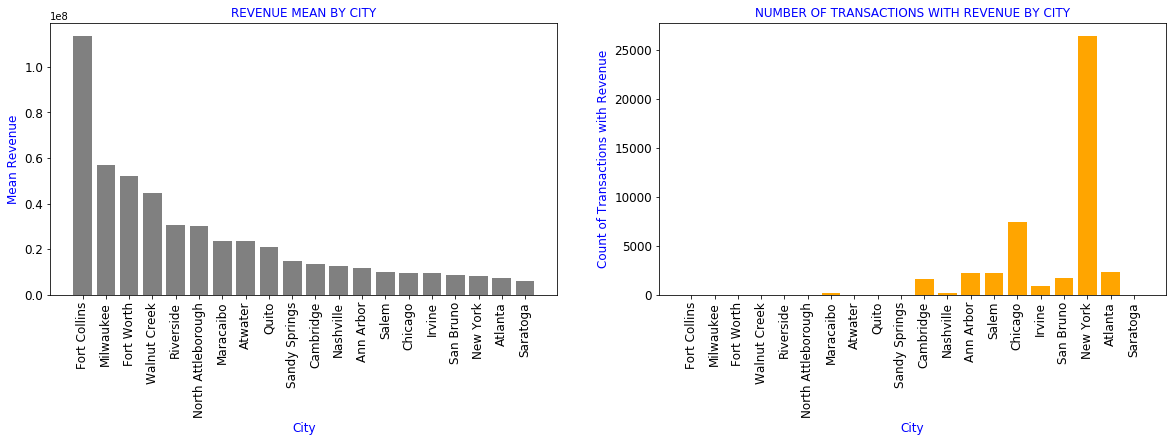

'SORTED BY Count of Transactions with Revenue'

,geoNetwork_city,totals_transactionRevenue_mean,revenue_status_count
365,Mountain View,3084426.18,40884
392,New York,8347939.40,26371
508,San Francisco,4962071.92,20329
557,Sunnyvale,3010360.69,13086
313,London,115808.68,12607
509,San Jose,1819250.12,10295
315,Los Angeles,4832333.33,8670
45,Bangkok,21393.18,7709
125,Chicago,9787013.70,7444
239,Ho Chi Minh City,0.00,7342


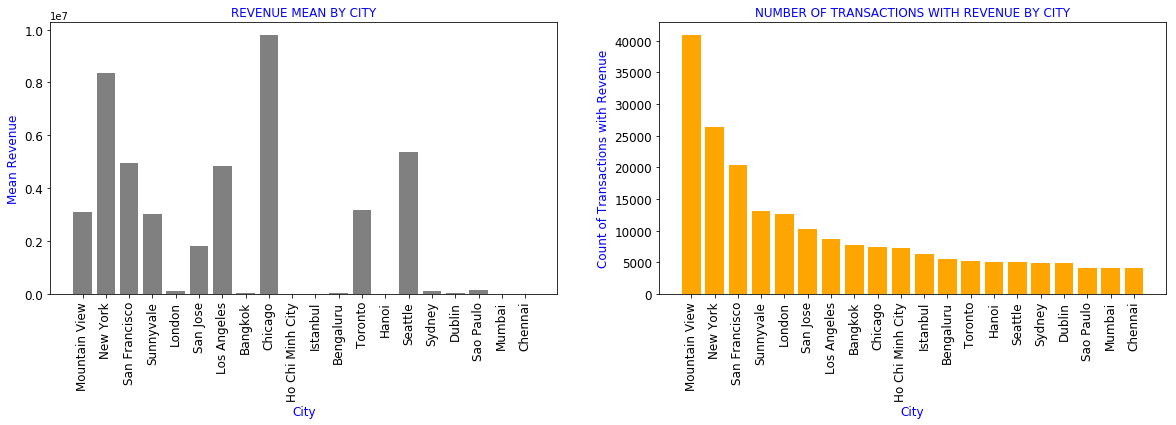

In [24]:
#REVENUE GENERATED BY CITY
df_con=df_train[['geoNetwork_city','totals_transactionRevenue','revenue_status']].groupby(df_train.geoNetwork_city).aggregate({'totals_transactionRevenue':['mean'],
                                                                                                              'revenue_status':['count']}).reset_index()
df_con.columns=['geoNetwork_city','totals_transactionRevenue_mean','revenue_status_count']
df=df_con.sort_values(by='totals_transactionRevenue_mean',ascending=False)[:20]
df1=df_con.sort_values(by='revenue_status_count',ascending=False)[:20]
display('SORTED BY Mean Revenue')
display(df.style.format(formatter))


plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY CITY',color='b',fontsize=12)
plt.xlabel('City',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df)),df.geoNetwork_city,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY CITY',color='b',fontsize=12)
plt.xlabel('City',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df)),df.revenue_status_count,color='orange')
plt.yticks(fontsize=12)
plt.xticks(range(len(df)),df.geoNetwork_city,rotation=90,fontsize=12)
plt.show()

display('SORTED BY Count of Transactions with Revenue')
display(df1.style.format(formatter))

plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('REVENUE MEAN BY CITY',color='b',fontsize=12)
plt.xlabel('City',color='b',fontsize=12)
plt.ylabel('Mean Revenue',color='b',fontsize=12)
plt.bar(range(len(df1)),df1.totals_transactionRevenue_mean,color='grey')
plt.xticks(range(len(df1)),df1.geoNetwork_city,rotation=90,fontsize=12)
plt.yticks(fontsize=12)


plt.subplot(1,2,2)
plt.title('NUMBER OF TRANSACTIONS WITH REVENUE BY CITY',color='b',fontsize=12)
plt.xlabel('City',color='b',fontsize=12)
plt.ylabel('Count of Transactions with Revenue',color='b',fontsize=12)
plt.bar(range(len(df1)),df1.revenue_status_count,color='orange')
plt.yticks(fontsize=12)
plt.xticks(range(len(df1)),df1.geoNetwork_city,rotation=90,fontsize=12)
plt.show()

In [25]:
#AS IDENTIFIED IN EDA COUNTRY Anguilla HAS A VERY HIGH VALUE SINGLE VISIT TRANSACTION
print('Dropping following observation:')
display(train_cpy[train_cpy.geoNetwork_country=='Anguilla'])

#DROPING THIS OUTLIER
train_cpy.drop(train_cpy[train_cpy.geoNetwork_country=='Anguilla'].index,axis=0,inplace=True)

#RESETING INDEX
train_cpy.reset_index(drop=True,inplace=True)

#COMBINING TRAIN AND TEST DATASET
df_combi=pd.concat([train_cpy,df_test],ignore_index=True)

#FEATURE SUMMARY FOR COMBINED DATASET
df_combi_fs=feature_summary(df_combi)
display(df_combi_fs)

Dropping following observation:


,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_deviceCategory,device_operatingSystem,device_isMobile,...,totals_bounces,totals_pageviews,totals_hits,totals_newVisits,totals_transactionRevenue,tsadclick_isVideoAd,tsadclick_page,tsadclick_gclId,tsadclick_slot,tsadclick_adNetworkType
433234,Organic Search,20170208,0403377724115575972,0403377724115575972_1486571908,1486571908,1,1486571908,mobile,iOS,True,...,NaN,15.0,18.0,1.0,10990000.0,NaN,NaN,NaN,NaN,NaN


DataFrame shape
rows: 1708336
cols: 35


,Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
channelGrouping,0,8,object,-,-,-,-,"[Organic Search, Referral, Paid Search, Affili..."
date,0,638,int64,20180430/20160801,2.01702e+07,6485.62,0.0464996,"[20160902, 20170126, 20170623, 20170312, 20170..."
fullVisitorId,0,1323729,object,-,-,-,-,"[1131660440785968503, 377306020877927890, 3895..."
sessionId,0,1706612,object,-,-,-,-,"[1131660440785968503_1472830385, 3773060208779..."
visitId,0,1665801,int64,1525157818/1470034812,1.49835e+09,1.62494e+07,-0.0864844,"[1472830385, 1472880147, 1472865386, 147288121..."
visitNumber,0,457,int64,457/1,2.33517,9.35404,21.045,"[1, 2, 3, 5, 11, 4, 57, 6, 56, 7, 20, 8, 15, 9..."
visitStartTime,0,1667422,int64,1525157818/1470034812,1.49835e+09,1.62494e+07,-0.0864844,"[1472830385, 1472880147, 1472865386, 147288121..."
device_deviceCategory,0,3,object,-,-,-,-,"[desktop, mobile, tablet]"
device_operatingSystem,11815,24,object,-,-,-,-,"[Windows, Macintosh, Linux, Android, iOS, Chro..."
device_isMobile,0,2,bool,-,-,-,-,"[False, True]"


In [26]:
#EXTRACTING DAY_OF_WEEK, HOUR, DAY, MONTH FROM DATE 
df_combi['date'] = pd.to_datetime(df_combi['visitStartTime'], unit='s')
df_combi['day_of_week'] = df_combi['date'].dt.dayofweek
df_combi['hour'] = df_combi['date'].dt.hour
df_combi['day'] = df_combi['date'].dt.day
df_combi['month'] = df_combi['date'].dt.month

#ADDING ANOTHER FEATURE revenue_status TO INDICATE PRESENCE/ABSENCE OF REVENUE FOR EACH OBSERVATION
df_combi['revenue_status']=df_combi.totals_transactionRevenue.apply(lambda x: 0 if x==0 else 1)

In [27]:
%%time
#CONVERTING ALL THE STRINGS IN CATEGORICAL FEATURES TO LOWER CASE
for col in df_combi.columns:
    if ((df_combi[col].dtype=='object') & (col!='fullVisitorId')):
        df_combi[col]=df_combi[col].apply(lambda x:str(x).lower())
        
#REPLACING STRING 'nan' WITH np.nan
df_combi.replace('nan',np.nan,inplace=True)

CPU times: user 31.3 s, sys: 2.79 s, total: 34 s
Wall time: 33.2 s


In [28]:
%%time
#CONVERTING CATEGORICAL FEATURES (LESS THAN 10 UNIQUE VALUES) TO DUMMIES
df_combi.drop(['device_isMobile'],axis=1,inplace=True)

cat_col=['channelGrouping','device_deviceCategory','tsadclick_slot','tsadclick_adNetworkType','tsadclick_isVideoAd','trafficSource_medium',
        'geoNetwork_continent']

for col in cat_col:
    df_combi[col]=df_combi[col].apply(lambda x: str(x).replace(" ","_"))
    
dummy=pd.DataFrame()

for col in cat_col:
    if col.find('_')!=-1:
        col_name=col.split('_')[1]
    else:
        col_name=col
    dummy=pd.concat([dummy,pd.get_dummies(df_combi[col],prefix=col_name)],axis=1)
    
print('Newly created dummy cols:',len(dummy.columns))
df_combi=pd.concat([df_combi,dummy],axis=1)

df_combi.drop(cat_col,axis=1,inplace=True)

Newly created dummy cols: 34
CPU times: user 10.7 s, sys: 1.32 s, total: 12 s
Wall time: 10.4 s


In [29]:
df_combi.head()

,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_operatingSystem,device_browser,geoNetwork_country,geoNetwork_city,...,medium_cpm,medium_nan,medium_organic,medium_referral,continent_africa,continent_americas,continent_asia,continent_europe,continent_nan,continent_oceania
0,2016-09-02 15:33:05,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,windows,chrome,turkey,izmir,...,0,0,1,0,0,0,1,0,0,0
1,2016-09-03 05:22:27,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,macintosh,firefox,australia,NaN,...,0,0,1,0,0,0,0,0,0,1
2,2016-09-03 01:16:26,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,windows,chrome,spain,madrid,...,0,0,1,0,0,0,0,1,0,0
3,2016-09-03 05:40:13,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,linux,uc browser,indonesia,NaN,...,0,0,1,0,0,0,1,0,0,0
4,2016-09-02 13:23:20,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,android,chrome,united kingdom,NaN,...,0,0,1,0,0,0,0,1,0,0


In [30]:
#SOME BASIC DATA CLEANUP
df_combi['totals_newVisits'].fillna(0,inplace=True) 
df_combi['totals_bounces'].fillna(0,inplace=True)
df_combi['tsadclick_page'].fillna(0,inplace=True)
df_combi['trafficSource_isTrueDirect'].replace({np.nan:0,'true':1},inplace=True)

In [31]:
%%time
#GENERATING RANKS FOR CATEGORICAL FEATURES WITH UNIQUE VALUES GREATER THAN 10
#RANKS ARE GENERATED USING REVENUE PERCENTAGE
cols=[x for x in df_combi.columns if x not in ['fullVisitorId','sessionId','geoNetwork_networkDomain','tsadclick_gclId']]

for col in cols:
    if df_combi[col].dtype=='object':
        df_combi[col].fillna('others',inplace=True)
        col_list=['revenue_status','totals_transactionRevenue']
        col_list.append(col)
        print(col_list)
        df=df_combi[col_list].groupby(col).aggregate({col:['count'],'revenue_status':['sum'],'totals_transactionRevenue':['sum']}).reset_index()
        df.columns=[col,col+"_count",'revenue_status_sum','totals_transactionRevenue_sum']
        df['revenue_perc']=df['totals_transactionRevenue_sum']/df[col+"_count"]
        df['rank']=df['revenue_perc'].rank(ascending=1)
        
        replace_dict={}
        final_dict={}
        for k,col_val in enumerate(df[col].values):
            replace_dict[col_val]=df.iloc[k,5]
        final_dict[col]=replace_dict
        df_combi.replace(final_dict,inplace=True)
        del df,replace_dict,final_dict
        gc.collect()

['revenue_status', 'totals_transactionRevenue', 'device_operatingSystem']
['revenue_status', 'totals_transactionRevenue', 'device_browser']
['revenue_status', 'totals_transactionRevenue', 'geoNetwork_country']
['revenue_status', 'totals_transactionRevenue', 'geoNetwork_city']
['revenue_status', 'totals_transactionRevenue', 'geoNetwork_subContinent']
['revenue_status', 'totals_transactionRevenue', 'geoNetwork_region']
['revenue_status', 'totals_transactionRevenue', 'geoNetwork_metro']
['revenue_status', 'totals_transactionRevenue', 'trafficSource_adContent']
['revenue_status', 'totals_transactionRevenue', 'trafficSource_referralPath']
['revenue_status', 'totals_transactionRevenue', 'trafficSource_keyword']
['revenue_status', 'totals_transactionRevenue', 'trafficSource_campaign']
['revenue_status', 'totals_transactionRevenue', 'trafficSource_source']
CPU times: user 14min 38s, sys: 10.9 s, total: 14min 49s
Wall time: 14min 41s


In [32]:
#SPLITING COMBINED DATASET BACK TO TRAIN AND TEST SETS
train=df_combi[:len(train_cpy)]
test=df_combi[len(train_cpy):]

In [33]:
train.head()

,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_operatingSystem,device_browser,geoNetwork_country,geoNetwork_city,...,medium_cpm,medium_nan,medium_organic,medium_referral,continent_africa,continent_americas,continent_asia,continent_europe,continent_nan,continent_oceania
0,2016-09-02 15:33:05,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,21.0,128.0,161.0,411.5,...,0,0,1,0,0,0,1,0,0,0
1,2016-09-03 05:22:27,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,23.0,129.0,206.0,889.0,...,0,0,1,0,0,0,0,0,0,1
2,2016-09-03 01:16:26,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,21.0,128.0,182.0,411.5,...,0,0,1,0,0,0,0,1,0,0
3,2016-09-03 05:40:13,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,22.0,60.5,210.0,889.0,...,0,0,1,0,0,0,1,0,0,0
4,2016-09-02 13:23:20,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,20.0,128.0,184.0,889.0,...,0,0,1,0,0,0,0,1,0,0


In [34]:
test.head()

,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_operatingSystem,device_browser,geoNetwork_country,geoNetwork_city,...,medium_cpm,medium_nan,medium_organic,medium_referral,continent_africa,continent_americas,continent_asia,continent_europe,continent_nan,continent_oceania
903652,2017-10-16 10:50:24,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,23.0,128.0,198.0,889.0,...,0,0,1,0,0,0,1,0,0,0
903653,2017-10-16 17:38:42,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,21.0,128.0,182.0,411.5,...,0,0,1,0,0,0,0,1,0,0
903654,2017-10-16 08:40:20,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,23.0,128.0,177.0,889.0,...,0,0,1,0,0,0,0,1,0,0
903655,2017-10-16 22:38:50,2376720078563423631,2376720078563423631_1508193530,1508193530,1,1508193530,19.0,125.0,223.0,924.0,...,0,0,1,0,0,1,0,0,0,0
903656,2017-10-17 05:17:22,2314544520795440038,2314544520795440038_1508217442,1508217442,1,1508217442,23.0,125.0,223.0,900.0,...,0,0,1,0,0,1,0,0,0,0


In [35]:
%%time
#REPLACING DOT WITH SPACE IN FEATURE geoNetwork_networkDomain
#THIS IS DONE TO TREAT IT AS TEXT AND WE WILL USE TfidfVectorizer TO EXTRACT FEATURES
train['geoNetwork_networkDomain'].fillna('unknown.unknown',inplace=True)
test['geoNetwork_networkDomain'].fillna('unknown.unknown',inplace=True)

train['geoNetwork_networkDomain']=train.geoNetwork_networkDomain.apply(lambda x: x.replace('.',' '))
test['geoNetwork_networkDomain']=test.geoNetwork_networkDomain.apply(lambda x: x.replace('.',' '))

CPU times: user 1.58 s, sys: 4.03 ms, total: 1.59 s
Wall time: 1.44 s


In [36]:
%%time
#USING TfidfVectorizer TO EXTRACT FEATURES FROM geoNetwork_networkDomain
Tvect=TfidfVectorizer(ngram_range=(1,2),max_features=20000)
vect=Tvect.fit(train['geoNetwork_networkDomain'])
train_vect=vect.transform(train['geoNetwork_networkDomain'])
test_vect=vect.transform(test['geoNetwork_networkDomain'])

#DIMENSIONALITY REDUCTION ON EXTRACTED FEATURES
svd=TruncatedSVD(n_components=10)

#CREATING DATAFRAMES AFTER FEATURE EXTRACTION AND REDUCTION
vect_cols=['vect'+str(x) for x in range(1,11)]
df_train_vect=pd.DataFrame(svd.fit_transform(train_vect),columns=vect_cols)
df_test_vect=pd.DataFrame(svd.fit_transform(test_vect),columns=vect_cols)

CPU times: user 27.3 s, sys: 4.44 s, total: 31.7 s
Wall time: 24.9 s


In [37]:
#VIEW OF EXTRACTED AND REDUCED FEATURES
print(train_vect.shape,test_vect.shape)
display(df_train_vect.head())
display(df_test_vect.head())
print('Shape of vector dataframes:',df_train_vect.shape,df_test_vect.shape)

(903652, 20000) (804684, 20000)


,vect1,vect2,vect3,vect4,vect5,vect6,vect7,vect8,vect9,vect10
0,3.463062e-06,4.528196e-04,0.517266,-2.251657e-03,7.904839e-01,-4.664773e-03,-0.325101,4.663916e-03,8.661429e-03,-2.643787e-03
1,3.380592e-07,9.234520e-02,0.005984,8.326570e-02,3.113814e-04,5.360757e-02,0.012733,7.114772e-03,4.254982e-02,-3.894472e-02
2,1.000000e+00,-5.903558e-07,-0.000010,-4.609594e-07,-3.689367e-07,-3.369240e-07,-0.000006,3.384416e-08,-2.748894e-08,1.087692e-07
3,1.000000e+00,-5.903555e-07,-0.000010,-4.609520e-07,-3.689347e-07,-3.369018e-07,-0.000006,3.384629e-08,-2.748579e-08,1.087653e-07
4,1.000000e+00,-5.903559e-07,-0.000010,-4.609429e-07,-3.689587e-07,-3.368384e-07,-0.000006,3.384968e-08,-2.744816e-08,1.087351e-07


,vect1,vect2,vect3,vect4,vect5,vect6,vect7,vect8,vect9,vect10
0,3.216823e-06,4.349479e-04,0.166820,2.150010e-04,-0.078759,1.922717e-03,-4.895536e-04,5.655149e-04,-1.690999e-03,7.059328e-04
1,1.830842e-07,1.254962e-01,0.000040,1.256359e-01,-0.005255,-1.230013e-01,-9.310746e-02,-3.394915e-02,-1.289241e-01,-3.579879e-02
2,2.336793e-07,1.495195e-01,0.000049,1.347574e-01,-0.002539,-1.184030e-01,-5.021128e-02,-3.599352e-02,-5.625882e-02,-2.051238e-02
3,1.000000e+00,-6.232164e-07,-0.000016,-4.784981e-07,0.000007,2.021912e-07,2.059469e-07,5.194549e-08,2.663749e-07,3.779066e-08
4,1.000000e+00,-6.232163e-07,-0.000016,-4.784997e-07,0.000007,2.021786e-07,2.059358e-07,5.194398e-08,2.663716e-07,3.779020e-08


Shape of vector dataframes: (903652, 10) (804684, 10)


In [38]:
X=train.drop(['sessionId','visitId','date','geoNetwork_networkDomain','tsadclick_gclId'],axis=1)
X_test=test.drop(['sessionId','visitId','date','geoNetwork_networkDomain','tsadclick_gclId'],axis=1)   

In [39]:
#REORDERING INDEX FOR TEST DATASET
#THIS IS REQUIRED BEFORE CONCATENATING DATAFRAMES
X_test.reset_index(drop=True,inplace=True)
X_test.head()

,fullVisitorId,visitNumber,visitStartTime,device_operatingSystem,device_browser,geoNetwork_country,geoNetwork_city,geoNetwork_subContinent,geoNetwork_region,geoNetwork_metro,...,medium_cpm,medium_nan,medium_organic,medium_referral,continent_africa,continent_americas,continent_asia,continent_europe,continent_nan,continent_oceania
0,6167871330617112363,2,1508151024,23.0,128.0,198.0,889.0,14.0,458.0,94.0,...,0,0,1,0,0,0,1,0,0,0
1,0643697640977915618,1,1508175522,21.0,128.0,182.0,411.5,9.0,202.5,94.0,...,0,0,1,0,0,0,0,1,0,0
2,6059383810968229466,1,1508143220,23.0,128.0,177.0,889.0,12.0,458.0,94.0,...,0,0,1,0,0,0,0,1,0,0
3,2376720078563423631,1,1508193530,19.0,125.0,223.0,924.0,23.0,471.0,107.0,...,0,0,1,0,0,1,0,0,0,0
4,2314544520795440038,1,1508217442,23.0,125.0,223.0,900.0,23.0,471.0,107.0,...,0,0,1,0,0,1,0,0,0,0


In [40]:
#CONCATENATING WITH TEXT FEATURES 
X=pd.concat([X,df_train_vect],axis=1)
X_test=pd.concat([X_test,df_test_vect],axis=1)

In [41]:
#VIEW OF TRAIN AND TEST DATASET SHAPE
print('Before creating aggregated features')
print('Train shape:',X.shape,' Test shape:',X_test.shape)

Before creating aggregated features
Train shape: (903652, 71)  Test shape: (804684, 71)


In [42]:
%%time
agg_func={}
agg_col=['fullVisitorId']
for col in [x for x in X.columns if x not in ['fullVisitorId']]:
    if col=='totals_transactionRevenue':
        agg_func[col]=['sum']
        agg_col.append(str(col)+'_sum')
    elif col=='revenue_status':
        agg_func[col]=['sum']
        agg_col.append(str(col)+'_sum')
    else:
        agg_func[col]=['sum','max','min','mean','var','std']
        agg_col.append(str(col)+'_sum')
        agg_col.append(str(col)+'_max')
        agg_col.append(str(col)+'_min')
        agg_col.append(str(col)+'_mean')
        agg_col.append(str(col)+'_var')
        agg_col.append(str(col)+'_std')
    
X=X.groupby(X.fullVisitorId).aggregate(agg_func).reset_index()
X.columns=agg_col

X_test=X_test.groupby(X_test.fullVisitorId).aggregate(agg_func).reset_index()
X_test.columns=agg_col

CPU times: user 1min 22s, sys: 9.83 s, total: 1min 32s
Wall time: 59.1 s


In [43]:
%%time

#CREATING y_dummy FOR USING STRATIFIED KFOLD
y_dummy=X.revenue_status_sum.apply(lambda x: 0 if x==0 else 1)

#TARGET FEATURE CONVERTED TO NATURAL LOG
# y=pd.Series(X['totals_transactionRevenue_sum'])
y=X.totals_transactionRevenue_sum.apply(lambda x: np.log1p(x))

#PEPARING DATA FOR TRAINING LGBM MODEL
X=X.drop(['totals_transactionRevenue_sum','fullVisitorId','revenue_status_sum'],axis=1)

#FINAL DATAFRAME FOR SUBMISSION
col=['fullVisitorId','totals_transactionRevenue_sum']
final=X_test[col] 
final.columns=['fullVisitorId','PredictedLogRevenue']

#FINAL TEST FEATURES USED FOR PREDICTING SUBMISSION
X_test=X_test.drop(['fullVisitorId','totals_transactionRevenue_sum','revenue_status_sum'],axis=1)

CPU times: user 2.05 s, sys: 1.31 s, total: 3.36 s
Wall time: 2.97 s


In [44]:
print('After creating aggregated features')
print('Train shape:',X.shape,' Test shape:',X_test.shape)

After creating aggregated features
Train shape: (714166, 408)  Test shape: (617242, 408)


In [45]:
%%time
#LGBMRegressor. THIS REQUIRES FURTHER PARAMETER TUNINIG
model=LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.01,n_estimators=1000,max_bin=255,subsample_for_bin=50000,
              objective=None,min_split_gain=0,min_child_weight=3,min_child_samples=10,subsample=1,subsample_freq=1,colsample_bytree=1,
              reg_alpha=0.1,reg_lambda=0,seed=17,silent=False,nthread=-1,n_jobs=-1)

 
k=1
splits=5
avg_score=0


skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
print('\nStarting KFold iterations...')
for train_index,test_index in skf.split(X,y_dummy):
    df_X=X.iloc[train_index,:]
    df_y=y.iloc[train_index]
    val_X=X.iloc[test_index,:]
    val_y=y.iloc[test_index]

    model.fit(df_X,df_y)

    preds_x=pd.Series(model.predict(val_X))
    acc=rsme(val_y,preds_x)
    print('Iteration:',k,'  rmse:',acc)
    
    if k==1:
        score=acc
        model1=model
        preds=pd.Series(model.predict(X_test))
        
    else:
        preds1=pd.Series(model.predict(X_test))
        preds=preds+preds1
        if score>acc:
            score=acc
            model1=model
    avg_score=avg_score+acc        
    k=k+1
print('\n Best score:',score,' Avg Score:',avg_score/splits)
preds=preds/splits


Starting KFold iterations...
Iteration: 1   rmse: 1.5820546945590404
Iteration: 2   rmse: 1.5843351233816856
Iteration: 3   rmse: 1.582710146946765
Iteration: 4   rmse: 1.5663858534077881
Iteration: 5   rmse: 1.5867835598088333

 Best score: 1.5663858534077881  Avg Score: 1.5804538756208226
CPU times: user 1h 7min 8s, sys: 56.4 s, total: 1h 8min 4s
Wall time: 17min 33s


<h2>Preparing Submission</h2>
While preparing submission we have to keep few points in mind
<ul>
<li>Number of observations in test set 804684
<li>Number of entries in submission file 617242
<li>Therefore after predicting will be will grouping predicted value on <i>fullVisitorId</i>, and 
<li>Then creating a join with submission dataframe to get final submission file
<li>I was missing this trick in first go and LB score was 2.005 :). Now it is 1.4431
</ul>
<h2>Score log</h2>
<ol>
<li>Score improved from 2.005 to 1.4431 by preparing predicted data
<li>By further data preparation score improved from 1.4431 to 1.4389
<li>Grouped data by <b>fullVisitorId</b> and applied aggregates score improved from 1.4389 to 1.4281 
<li>Score further improved from 1.4281 to 1.470 by converting feature <b>geoNetwork_networkDomain</b> into text and using TfidfVectorizer for text feature extraction
<li>Score is improved from 1.4270 to 1.4260 by dropping observation for country <b>Anguilla</b>. This improvement is direct outcome of EDA
 </ol>

In [48]:
#PREPARING PREDICTED DATA
final['PredictedLogRevenue']=pd.Series(preds)
#GROUPING PREDICTED DATA ON fullVisitorId
final = final.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
final.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [49]:
final

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.072512
1,0000049363351866189,0.004040
2,0000053049821714864,0.002420
3,0000059488412965267,0.005446
4,0000085840370633780,0.002401
5,0000091131414287111,0.002420
6,0000117255350596610,6.684056
7,0000118334805178127,0.002420
8,0000130646294093000,0.002420
9,0000150005271820273,0.002420


In [50]:
#READING SUMISSION FILE
submission=pd.read_csv('../input/sample_submission.csv')

#CREATING JOIN BETWEEN PREDICTED DATA WITH SUBMISSION FILE
submission=submission.join(final.set_index('fullVisitorId'),on='fullVisitorId',lsuffix='_sub')
submission.drop('PredictedLogRevenue_sub',axis=1,inplace=True)

#HANDLING NaN IN CASE OF MISSING fullVisitorId
submission.fillna(0,inplace=True)

#SUBMITING FILE
submission.to_csv('LGBM_submission.csv',index=False)

In [ ]:
#REVIEWING SUBMITED FILE
# submission